In [65]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

In [66]:
nx = 800
ny = 800 # 5mm
steps = 20000
output_stride = 500
profile_interval = 500

In [67]:
molecular_weights = np.array([1,80, 17, 8]) # H2, TMIn, PH3, CH4
n_species = len(molecular_weights)
multiplier = 56

phi_1 = 0.487
phis = phi_1 * molecular_weights[0]/molecular_weights
print(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

[0.487      0.0060875  0.02864706 0.060875  ]
viscosity_kinematic =  0.05185588011048307


In [68]:
D_s = 1/(multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights))
print('D_s = ',D_s)

D_s =  [0.02525381 0.0179684  0.01837485 0.01894036]


In [69]:
vx = 0.002
v_top = xp.array([vx, 0])
c_top = xp.array([0.979, 0.000047, 0.0204, 1e-4])
print("ratio = ", c_top[2]/c_top[1])
print(np.sum(c_top))
absorption_ratio = xp.array([0,1,1,-3])
print(3*c_top)

ratio =  434.04255319148945
0.999547
[2.937e+00 1.410e-04 6.120e-02 3.000e-04]


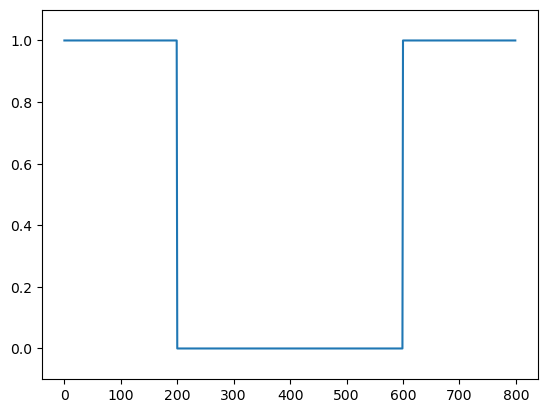

In [70]:
absorption_coefficient = 130

non_absorb_mask = xp.zeros(nx)
#non_absorb_mask[:nx//2] = True
non_absorb_mask[:] = True
non_absorb_mask[nx//4:-nx//4] = False
plt.plot(to_numpy(non_absorb_mask))
plt.ylim([-0.1, 1.1])

comp2_bc = xp.array([absorption_coefficient, 1, 0])

In [71]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
    D_s=xp.array(D_s),
    v_top = v_top, # vx, vy
    c_top = c_top, # partial pressure
    non_absorb_mask=xp.array(non_absorb_mask),
    comp2_bc =comp2_bc,
    absorption_ratio = xp.array(absorption_ratio),
)

In [72]:

vx_ini = vx
total_pressure = 1
partial_pressure = c_top

y_coord = xp.arange(ny)

# initialize linear profile
velocity_profile = vx_ini * y_coord/ny

# quadratic profile:
eta = y_coord/(ny-1)
velocity_profile = 4.0 * vx_ini * eta * (1.0 - eta)

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]

uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)
rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, lbm_config, ux_s, uy_s)
f = feq

f_cross_ini = feq[:, :, nx//2, :]

f_end = None

In [73]:
def main(f, lbm_config):
    velocity_field = []
    clip_history = []
    f_cross = []
    for step in tqdm(range(lbm_config.steps + 1)):
        if step % output_stride == 0:
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, lbm_config)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), step, zoom = 1/vx/5, skip = nx//40, save = True)
            save_concentration_frames(f, step, lbm_config)
            #plt.plot(to_numpy(rho_s[1, :, 0]))
            #plt.show()


        f, clipped = bgk_step(f, lbm_config, tube_flow_bottom_absorb)

        clip_history.append(clipped)
        if step % profile_interval == 0:
            f_cross.append(f[1, :, nx//2, :])

        if step == steps:
            break

    return np.array(velocity_field), np.array(clip_history), to_numpy(xp.array(f_cross)), to_numpy(f)

In [74]:
try:
    f = xp.array(f_end)
except:
    print("no previous result")
velocity_field,clip_history, f_cross, f_end = main(f, lbm_config)
np.save("f_simulation", f_end)

no previous result


100%|█████████▉| 20000/20001 [23:42<00:00, 14.06it/s] 


In [49]:
np.save("f_simulation_tube_flow_100", f_end)

(4, 9, 800, 800)
(4, 800, 800)
normalized_slope =  77.32754128944434
b1_measured =  136.4885964838339


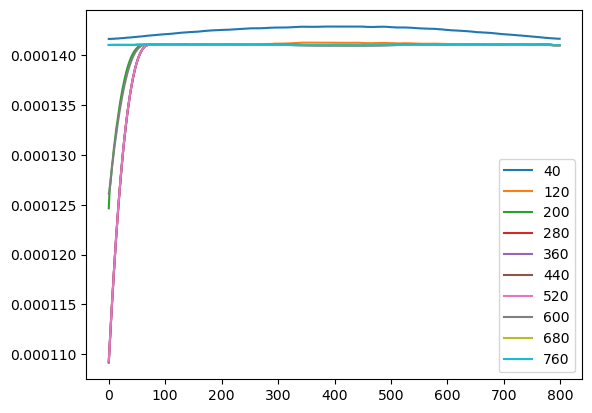

In [55]:
print(f_end.shape)
rho_s = xp.sum(f_end, axis = 1, dtype = DTYPE)
print(rho_s.shape)
for i in range(10):
    plt.plot(rho_s[1, i*(nx//10)+nx//20, :], label = f'{i*(nx//10)+nx//20}')
plt.legend()

L_grid = 0.038 / (nx/2)

slope_length = 5
normalized_slope = (rho_s[1, nx//2, slope_length]-rho_s[1, nx//2, 0])/slope_length/(3*c_top[1])/L_grid
slope = (rho_s[1, nx//2, slope_length]-rho_s[1, nx//2, 0])/slope_length
print("normalized_slope = ", normalized_slope)
b1_measured = rho_s[1, 50, 0]/slope
print("b1_measured = ", b1_measured)

In [64]:
c_w_ratio_guess = 0.8
target_norm_slope = 65
b1_estimate = c_w_ratio_guess/target_norm_slope/L_grid
print(b1_estimate)

129.55465587044534


In [43]:
slope2 = (rho_s[1, nx//2, 5]-rho_s[1, nx//2, 0])/5
flux2 = slope2 * D_s[1]
#print(flux2)
slope3 = (rho_s[2, nx//2, 5]-rho_s[2, nx//2, 0])/5
flux3 = slope3 * D_s[2]
print(flux3/flux2)
slope4 = (rho_s[3, nx//2, 5]-rho_s[3, nx//2, 0])/5
flux4 = slope4 * D_s[3]
print(flux4/flux2)

0.5752203295404327
-2.9973630988313746


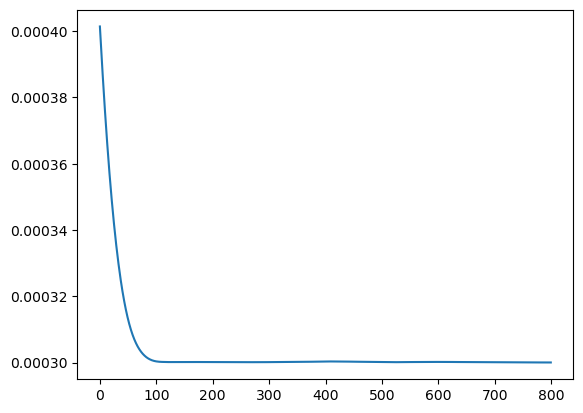

In [44]:
plt.plot(rho_s[3, nx//2, :])

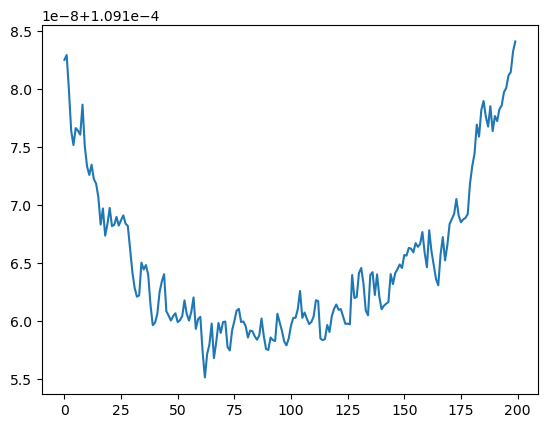

In [45]:
plt.plot(rho_s[1, 300:500, 0])

(41, 2, 4, 800, 800)
(41, 800)


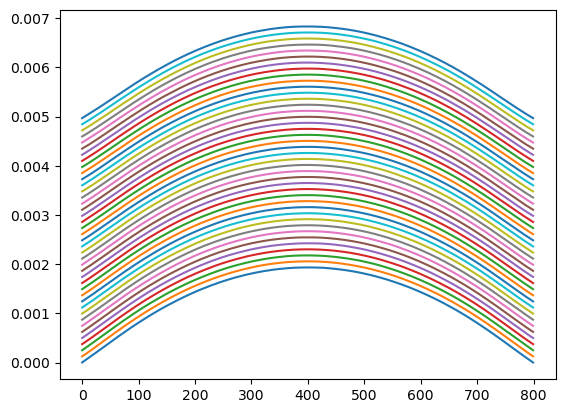

In [46]:
print(velocity_field.shape)
# frames, components, species, nx, ny

vx_profile = velocity_field[:, 0, 0, nx//2, :]
print(vx_profile.shape)
for i in range(vx_profile.shape[0]):
    plt.plot(vx_profile[i, :]+i*np.mean(vx_profile)*1e-1)

(41, 9, 800)
(40,)


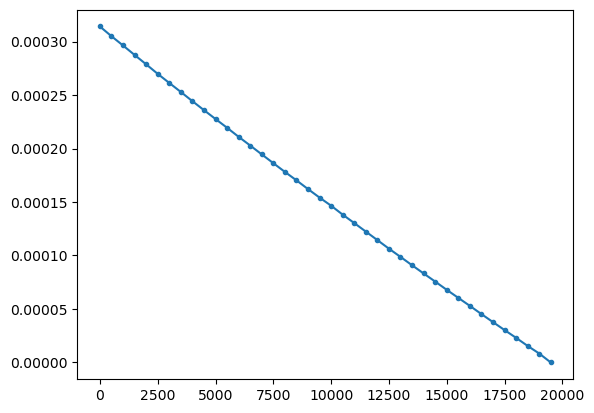

In [47]:
err = []
print(f_cross.shape)
for i in range(f_cross.shape[0]-1):
    error = np.sum(np.abs(f_cross[-i-1] - f_cross[-1]))
    err.append(error)
err = np.array(err)
print(err.shape)
plt.plot(np.arange(len(err))*profile_interval, err[::-1], marker = ".")

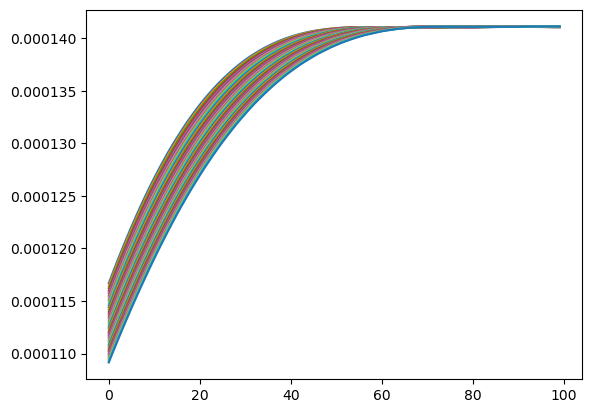

In [48]:
y_concentration_profile = np.sum(np.array(f_cross), axis = 1)
for i in range(y_concentration_profile.shape[0]):
    plt.plot(y_concentration_profile[i, :100])

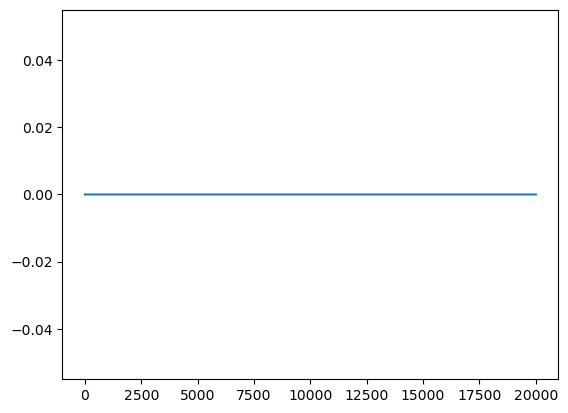

In [36]:
plt.plot(clip_history)